In [9]:
# Loading packages

# Path and file, data handling
import os
import h5py
import numpy as np
import pandas as pd
from pathlib import Path

# Image preprocessing
from skimage.io import imread
import cv2
from PIL import Image

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Splitting dataset
from sklearn.model_selection import train_test_split

# Image Augmentation
import imgaug as aug
import imgaug.augmenters as iaa

# pakcages for deep learnnig

# from tensorflow.keras import backend as K
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.optimizers import Adam, RMSprop, SGD
# from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
# # from tensorflow.keras.preprocessing import image_dataset_from_directory
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
# from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D, GlobalMaxPooling2D, BatchNormalization, Concatenate


In [10]:
data_dir = Path('D:/Projects/Covid19/data/')

train_dir = data_dir / 'Original_cropped'

train_dir

WindowsPath('D:/Projects/Covid19/data/Original_cropped')

In [3]:
# Check images are 'RGB' or not

# def is_grey_scale(img_path):
# #     img = Image.open(img_path).convert('RGB')
#     w,h = img.size
#     for i in range(w):
#         for j in range(h):
#             r,g,b = img.getpixel((i,j))
#             if r != g != b: return False
#     return True

In [4]:
# for image in train_dir.glob('OTHER/*'):
#     object = is_grey_scale(image)
#     print(object)

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2) # set validation split
    
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=4,
    color_mode="rgb",
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(224, 224),
    batch_size=4,
    color_mode="rgb",
    class_mode='categorical',
    subset='validation') # set as validation data

Found 1292 images belonging to 3 classes.
Found 322 images belonging to 3 classes.


In [6]:
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(rate = 0.3, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(rate = 0.5, name='dropout2')(x)
    x = Dense(3, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

model =  build_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0     

In [7]:
# Open the VGG16 weight file
f = h5py.File('D:/Projects/Covid19/VGG16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

# Select the layers for which you want to set weight.

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary() 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0     

In [8]:
# opt = RMSprop(lr=0.0001, decay=1e-6)

top_weights_path = os.path.join(os.path.abspath("D:/Projects/Covid19/Model/VGG16Depthwise/"), 'VGG16Depthwise_weights.h5')


opt = Adam(lr=0.0001, decay=1e-5)

es = EarlyStopping(monitor='val_accuracy', patience=5)
chkpt = ModelCheckpoint(filepath=top_weights_path, monitor='val_accuracy',save_best_only=True, save_weights_only=True)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

In [9]:
nb_epochs = 50

# Define the number of training steps
nb_train_steps = train_generator.samples//train_generator.batch_size
nb_val_steps = validation_generator.samples//validation_generator.batch_size


print("Number of training and validation steps: {} and {}".format(nb_train_steps, nb_val_steps))

Number of training and validation steps: 323 and 80


In [10]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_steps,
    validation_data = validation_generator, 
    validation_steps = nb_val_steps,
    epochs = nb_epochs)

Epoch 1/50
323/323 [==============================] - 97s 299ms/step - loss: 1.0399 - accuracy: 0.4288 - val_loss: 1.1294 - val_accuracy: 0.3531
Epoch 2/50
323/323 [==============================] - 95s 294ms/step - loss: 0.9627 - accuracy: 0.5193 - val_loss: 1.0284 - val_accuracy: 0.4719
Epoch 3/50
323/323 [==============================] - 95s 294ms/step - loss: 0.9218 - accuracy: 0.5534 - val_loss: 0.9582 - val_accuracy: 0.5500
Epoch 4/50
323/323 [==============================] - 94s 293ms/step - loss: 0.8376 - accuracy: 0.6161 - val_loss: 0.8420 - val_accuracy: 0.6469
Epoch 5/50
323/323 [==============================] - 93s 288ms/step - loss: 0.7455 - accuracy: 0.6827 - val_loss: 0.8328 - val_accuracy: 0.6313
Epoch 6/50
323/323 [==============================] - 93s 289ms/step - loss: 0.6604 - accuracy: 0.7113 - val_loss: 0.7086 - val_accuracy: 0.6875
Epoch 7/50
323/323 [==============================] - 93s 288ms/step - loss: 0.6028 - accuracy: 0.7562 - val_loss: 0.7945 - val_ac

# Evaluation

## Accuracy Graph

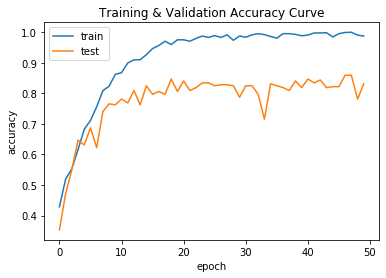

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training & Validation Accuracy Curve')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Loss Graph

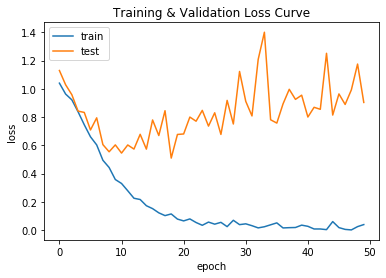

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Training & Validation Loss Curve")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
# model.save('D:/Projects/Covid19/Model/VGG16Depthwise/VGG16Depthwise_weights.h5')